In [ ]:
from google.colab import drive
from zipfile import ZipFile

drive.mount('/content/drive')
file_name='/content/drive/My Drive/Colab Notebooks/Malaria Detector/Dataset.zip'
with ZipFile(file_name,'r') as zip:
          zip.extractall()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from PIL import Image
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg19 import VGG19, preprocess_input
from keras import metrics, Model, layers
from keras.callbacks import *
from keras.models import load_model, model_from_json

In [ ]:
data_dir = '/content/cell_images'
parasitized_data = list(Path(data_dir+'/Parasitized/').rglob('*.png'))
uninfected_data = list(Path(data_dir+'/Uninfected/').rglob('*.png'))

In [ ]:
workingDir = "/content"

PATH = os.path.sep.join([workingDir, "cell_images"])

# Getting the path to the training directory 
train_dir = os.path.join(PATH, "cell_images")

# Getting the path to the validation directory 
validation_dir = os.path.join(PATH, "cell_images")

In [ ]:
# Getting the path to the directory for the parasitized training cell images and 
# the getting the path to the directory for the uninfected training cell images 
parasitized_train_dir = os.path.join(train_dir, "Parasitized")
uninfected_train_dir = os.path.join(train_dir, "Uninfected")

# Getting the path to the directory for the parasitized validation cell images and 
# the path to the directory for the uninfected validation cell images 
parasitized_val_dir = os.path.join(validation_dir, "Parasitized") 
uninfected_val_dir = os.path.join(validation_dir, "Uninfected")

In [ ]:
# Getting the number of images present in the parasitized training directory and the 
# number of images present in the uninfected training directory 
parasitized_images = len(os.listdir(parasitized_train_dir))
uninfected_images = len(os.listdir(uninfected_train_dir))

# Getting the number of images present in the parasitized validation directory and the 
# number of images present in the uninfected validation directory 
parasitized_images_val = len(os.listdir(parasitized_val_dir)) 
uninfected_images_val = len(os.listdir(uninfected_val_dir)) 

# Getting the sum of both the training images and validation images 
total_train = parasitized_images + uninfected_images  
total_val = parasitized_images_val + uninfected_images_val 

# Displaying the results for Training images  
print("Total Training parasitized images: {}".format(parasitized_images)); 
print("Total Training uninfected images: {}".format(uninfected_images)); 
print("__________________________________________________________________________________________________________\n");

# Displaying the results for Validation images  
print("Total Validation parasitized images: {}".format(parasitized_images_val)); 
print("Total Validation uninfected images: {}".format(uninfected_images_val)); 
print("__________________________________________________________________________________________________________\n"); 

# Displaying the total values for the images in both the training and validation directory 
print("Total Train: {}".format(total_train)); 
print("Total Validation: {}".format(total_val)); 

Total Training parasitized images: 13780
Total Training uninfected images: 13780
__________________________________________________________________________________________________________

Total Validation parasitized images: 13780
Total Validation uninfected images: 13780
__________________________________________________________________________________________________________

Total Train: 27560
Total Validation: 27560


In [ ]:
batch_size = 2000
epochs = 10 
IMG_HEIGHT = 98 
IMG_WIDTH = 98 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    shuffle = True
                                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(directory = validation_dir,
                                                  target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True
                                                 )

Found 27558 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.


In [ ]:
# instantiating the VGG19 model
vgg19 = VGG19(input_shape=[IMG_HEIGHT, IMG_WIDTH] + [3],
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = Flatten()(vgg19.output)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
# create a model object
model = Model(inputs = vgg19.input, outputs = prediction)

# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 98, 98, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 98, 98, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 98, 98, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 49, 49, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 49, 49, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 49, 49, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

In [ ]:
# tell the model what cost and optimization method to use

metrics = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
          ]

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=metrics
)

In [ ]:
# Training the model on the input data by using the fit_generator function 
history = model.fit_generator(train_generator, steps_per_epoch = total_train // batch_size, 
                       epochs = epochs, 
                       validation_data = validation_generator, 
                       validation_steps = total_val // batch_size) 

<ipython-input-26-bcd1411c8906>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch = total_train // batch_size,


Epoch 1/10
13/13 [==============================] - 182s 14s/step - loss: 0.6555 - accuracy: 0.6130 - precision: 0.6148 - recall: 0.6075 - val_loss: 0.5768 - val_accuracy: 0.6772 - val_precision: 0.6185 - val_recall: 0.9238
Epoch 2/10
13/13 [==============================] - 136s 11s/step - loss: 0.5232 - accuracy: 0.7646 - precision: 0.7604 - recall: 0.7741 - val_loss: 0.4838 - val_accuracy: 0.7642 - val_precision: 0.6995 - val_recall: 0.9289
Epoch 3/10
13/13 [==============================] - 135s 11s/step - loss: 0.4510 - accuracy: 0.8188 - precision: 0.8101 - recall: 0.8323 - val_loss: 0.4255 - val_accuracy: 0.8097 - val_precision: 0.7458 - val_recall: 0.9387
Epoch 4/10
13/13 [==============================] - 133s 10s/step - loss: 0.4047 - accuracy: 0.8480 - precision: 0.8323 - recall: 0.8722 - val_loss: 0.3853 - val_accuracy: 0.8347 - val_precision: 0.7776 - val_recall: 0.9377
Epoch 5/10
13/13 [==============================] - 133s 10s/step - loss: 0.3753 - accuracy: 0.8605 - pr

In [ ]:
model_test_performace = model.evaluate(validation_generator)

14/14 [==============================] - 41s 3s/step - loss: 0.3070 - accuracy: 0.8670 - precision: 0.8080 - recall: 0.9629


In [ ]:
# Saving the model for further uses 
modelName = "MalariaModel.h5" 
model.save_weights(modelName); 

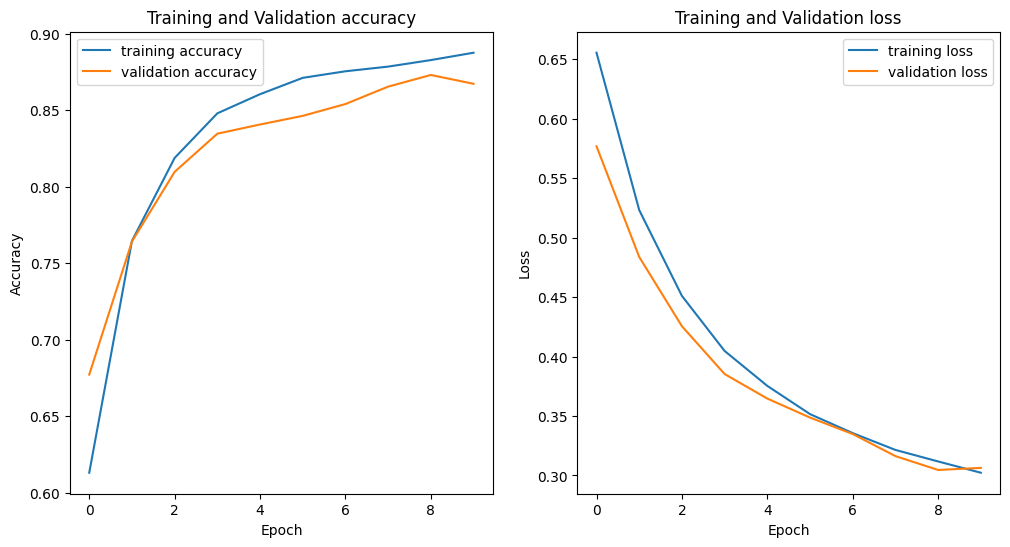

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'], label='training accuracy')
ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
ax[0].set_title('Training and Validation accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='training loss')
ax[1].plot(history.history['val_loss'], label='validation loss')
ax[1].set_title('Training and Validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

14/14 [==============================] - 42s 3s/step


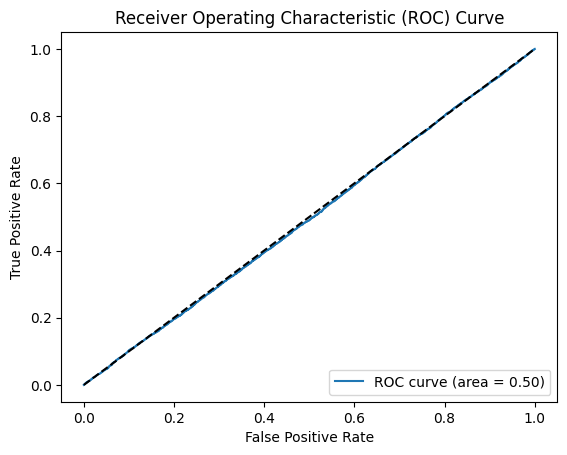

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for validation set
y_pred = model.predict(validation_generator).ravel()

# Calculate False Positive Rate, True Positive Rate and AUC
fpr, tpr, thresholds = roc_curve(validation_generator.classes, y_pred)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


14/14 [==============================] - 41s 3s/step


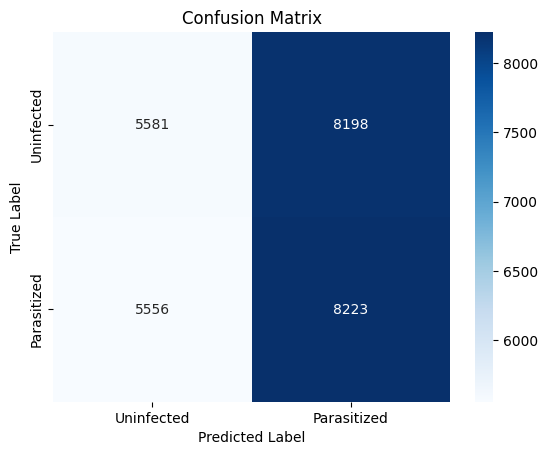

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate predictions for validation set
y_pred = model.predict(validation_generator).ravel()
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

# Calculate confusion matrix
conf_mat = confusion_matrix(validation_generator.classes, y_pred_classes)

# Plot confusion matrix as heatmap
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Uninfected', 'Parasitized'], 
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
